In [1]:
%%capture
import os
for dirname, _, filename in os.walk("../input"):
  for files in filename:
    print(os.path.join(dirname, files))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
%matplotlib inline
import cv2
from tqdm import tqdm_notebook as tqdm

# Data Reading

In [3]:
train_data = pd.DataFrame(pd.read_csv("../input/plant-pathology-2020-fgvc7/train.csv"))
test_data = pd.DataFrame(pd.read_csv("../input/plant-pathology-2020-fgvc7/test.csv"))

In [4]:
print("Training data shape : = {}".format(train_data.shape))
print("Test data shape : = {}".format(test_data.shape))

Training data shape : = (1821, 5)
Test data shape : = (1821, 1)


###### train_data.head()

In [5]:
test_data.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [6]:
image_folder_path = "../input/plant-pathology-2020-fgvc7/images/"

In [7]:
arr = train_data["image_id"]
train_images = [i for i in arr]  

arr = test_data["image_id"]
test_images = [i for i in arr]

In [8]:
def load_image(image_id) : 
  image_path = image_folder_path +image_id +".jpg"
  image = cv2.imread(image_path) 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  return image

def resize(image):
  image = cv2.resize(image, (800, 800))
  return image

# Exploratory Data Analysis

When we’re getting started with a machine learning (ML) project, one critical principle to keep in mind is that data is everything. It is often said that if ML is the rocket engine, then the fuel is the (high-quality) data fed to ML algorithms. However, deriving truth and insight from a pile of data can be a complicated and error-prone job. To have a solid start for our ML project, it always helps to analyze the data up front.

During EDA, it’s important that we get a deep understanding of:

* The properties of the data, such as schema and statistical properties;
* The quality of the data, like missing values and inconsistent data types;
* The predictive power of the data, such as correlation of features against target.

In [9]:
def extract_classes(s):
  """
  s can be either of the four classes mentioned above.
  """ 
  t = train_data[train_data[s] == 1] 
  arr = t["image_id"]
  images = [i for i in tqdm(arr)]
  train_images = [load_image(i) for i in tqdm(images)]
  return train_images

classes = ["healthy", "multiple_diseases", "rust", "scab"] 

In [10]:
count_healthy = len(train_data[train_data["healthy"] == 1])
count_diseased = len(train_data[train_data["multiple_diseases"] == 1])
count_rust = len(train_data[train_data["rust"] == 1])
count_scab = len(train_data[train_data["scab"] == 1])

print(count_healthy)
print(count_diseased)
print(count_rust)
print(count_scab)
print(count_healthy + count_diseased + count_rust +  count_scab)

516
91
622
592
1821


(-1.1527958829887197,
 1.1533529919548287,
 -1.1585919775752163,
 1.1357509855075638)

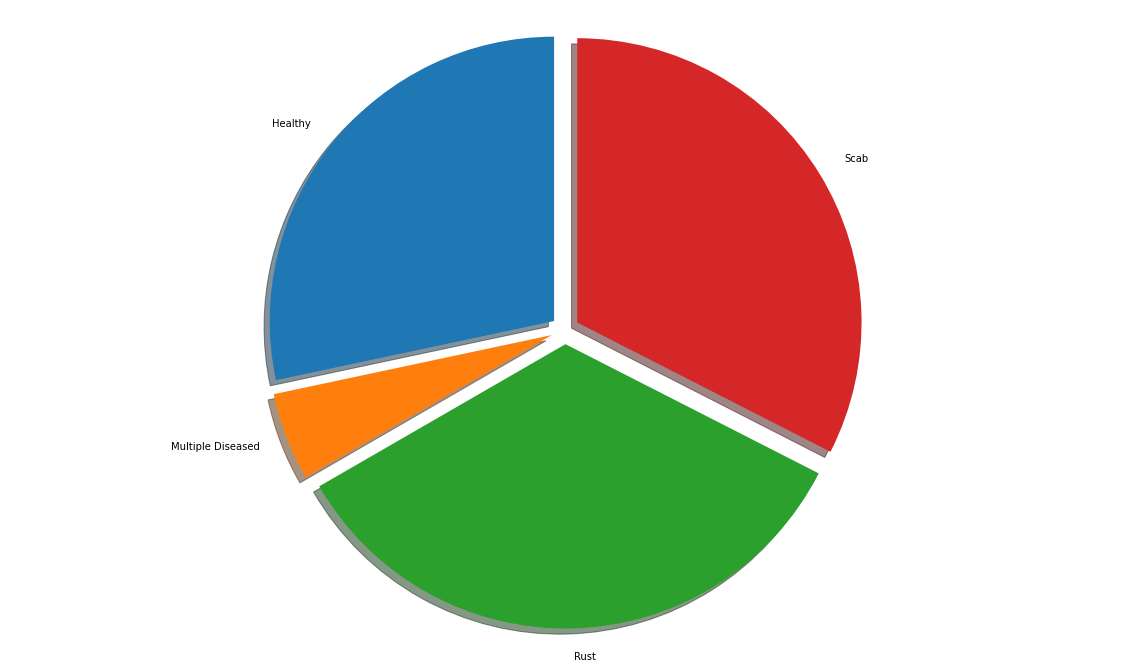

In [11]:
# observe number of cases present in each class
labels = ["Healthy", "Multiple Diseased", "Rust", "Scab"]
counts = [count_healthy, count_diseased, count_rust, count_scab]
explode = (0.05, 0.05, 0.05, 0.05)
fig, ax = plt.subplots(figsize = (20, 12))
ax.pie(counts, explode = explode, labels = labels, shadow = True, startangle = 90)
ax.axis("equal") # equal aspect ratio ensures pie graph is drawn as circle

Clearly, there is a class imbalance problem which needs to be addressed during the deep learning model construction.

In [12]:
red , green, blue = [], [], []

## Analysing the color channel distribution in each Image 

In [13]:
healthy = extract_classes("healthy")
for image in healthy :
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)
    
healthy_image_1 = healthy[100]
healthy_image_2 = healthy[200]
healthy_image_3 = healthy[300]
del healthy # free memory

md = extract_classes("multiple_diseases")
for image in md : 
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)
md_image_1 = md[1]
md_image_2 = md[5]
md_image_3 = md[10]
del md # free memory

rust = extract_classes("rust")
for image in rust : 
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)
rust_image_1 = rust[10]
rust_image_2 = rust[20] 
rust_image_3 = rust[30]
del rust # free memory

scab = extract_classes("healthy")
for image in scab : 
    mean_red = np.mean(image[:,:,0])
    mean_green = np.mean(image[:,:,1])
    mean_blue = np.mean(image[:,:,2])
    
    red.append(mean_red)
    green.append(mean_green)
    blue.append(mean_blue)
scab_image_1 = scab[10]
scab_image_2 = scab[20]
scab_image_3 = scab[30] 
del scab # free memory

image_collection = [healthy_image_1, healthy_image_2, healthy_image_3, 
                   md_image_1, md_image_2, md_image_3,
                   rust_image_1, rust_image_2, rust_image_3,
                   scab_image_1, scab_image_2, scab_image_3]   

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


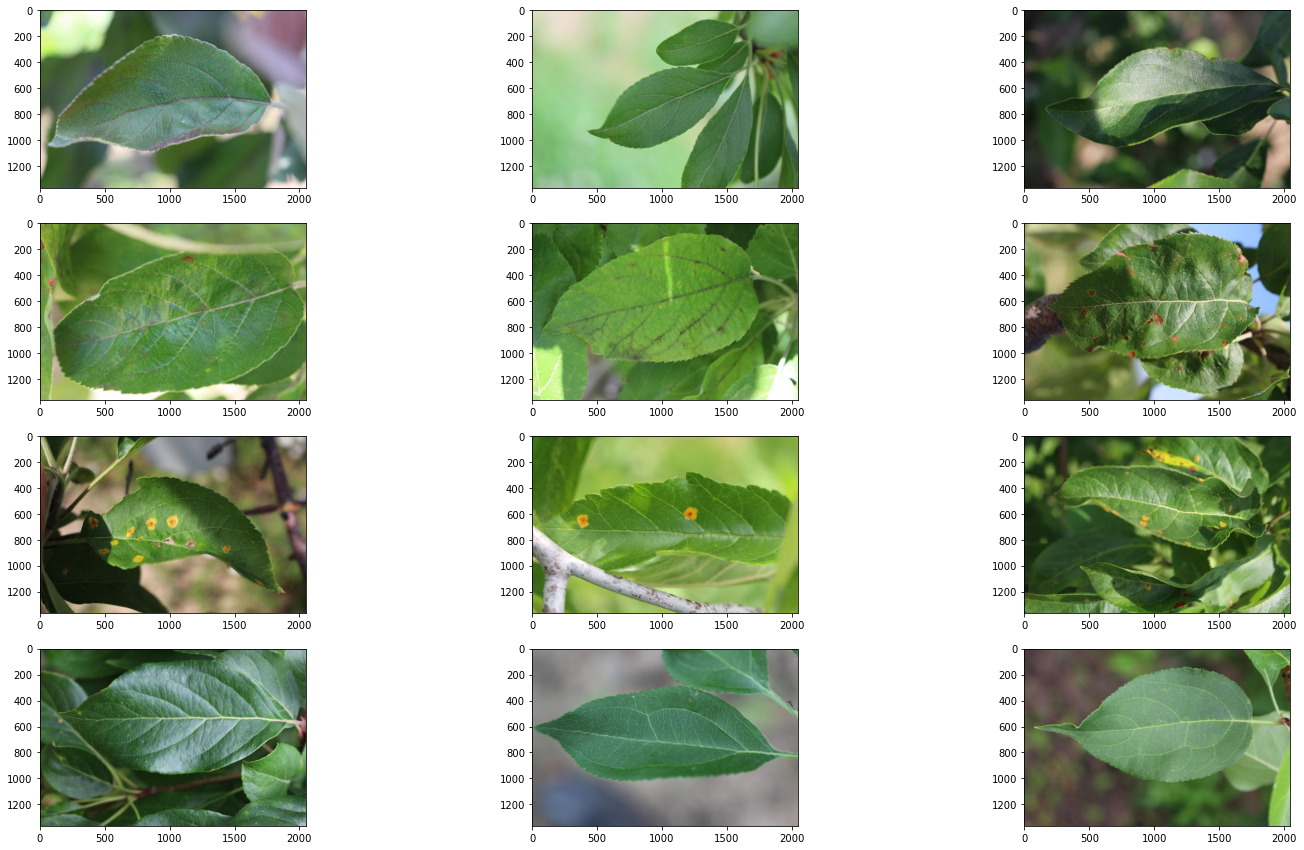

In [14]:
fig, ax = plt.subplots(nrows = 4, ncols = 3, figsize = (25, 15))
for i in range(12):
    ax[i//3, i%3].imshow(image_collection[i]) 

**Inference** : 
* Rust leaves has brownish- yellowish patches
* Scab leaves have brown stains.

## Skewness in EDA :

Skewness is the measure of symmetry or asymmetry of a data distribution. A distribution or data set is said to be symmetric if it looks same to the left and right point of the center.

Types of Skewness :

Skewness is generally classified into 2 broad categories-

* Right skewness or Positive skewness
* Left skewness or Negative skewness

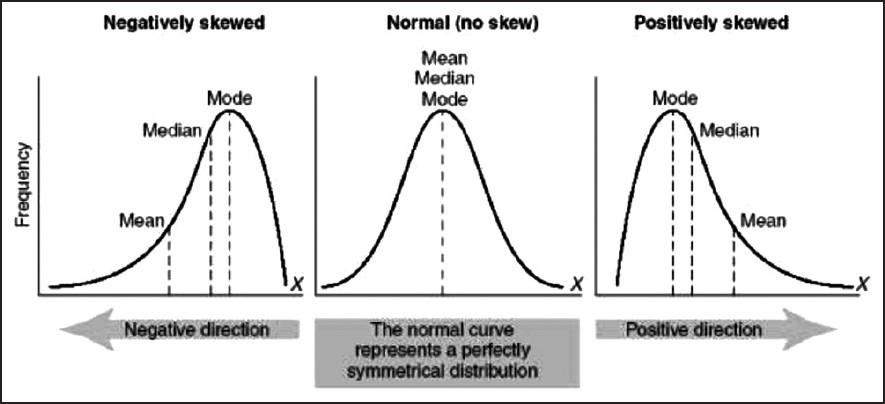

It is very difficult to interpret and analyse the data which is skewed.

## Kurtosis :

Kurtosis is the characteristics of being flat or peaked. It is a measure whether data is heavy- tailed or light-tailed in a normal distribution

A large kurtosis value often mean that the tails of the distributions are getting toward more extreme values than the tails of normal distributions. This may lead to a length of 6 or 7 standard deviation from the mean. Similarly, If the kurtosis value is very low, then the tails of the distributions will be less lengthier than the those of a normal distribution (less than 3 standard deviation).

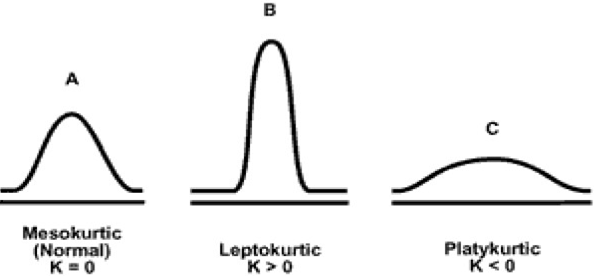

A large value of kurtosis is often considered as more risky because data may tend to give an outlier value as outcome with greater distance from the mean if applied to any machine learning algorithm.

The range of spread = 121.38


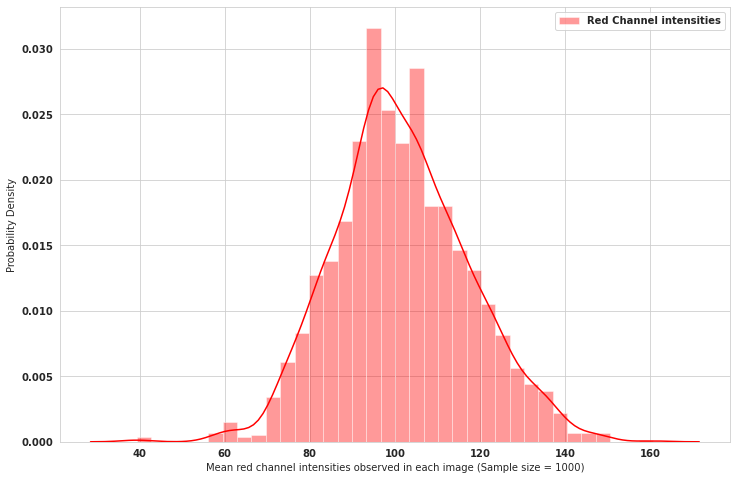

In [15]:
# red channel plot
range_of_spread = max(red) - min(red)
plt.figure(figsize = (12, 8))
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(red,  hist = True, kde = True, label = "Red Channel intensities", color = "r")
fig.set(xlabel = "Mean red channel intensities observed in each image (Sample size = 1000)", ylabel = "Probability Density")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 98.29


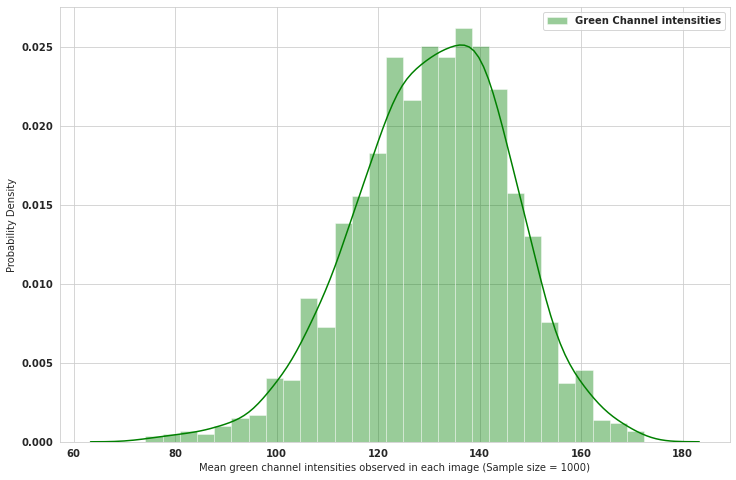

In [16]:
# Green channel plot
range_of_spread = max(green) - min(green)
plt.figure(figsize = (12, 8))
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(green,  hist = True, kde = True, label = "Green Channel intensities", color = "g")
fig.set(xlabel = "Mean green channel intensities observed in each image (Sample size = 1000)", ylabel = "Probability Density")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

The range of spread = 99.43


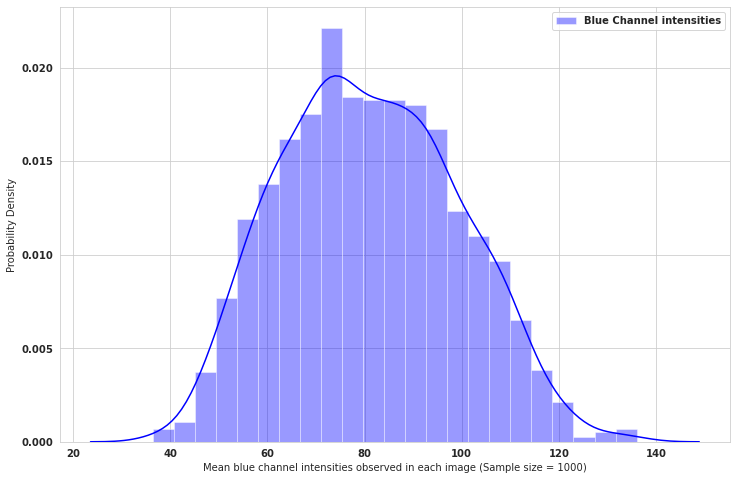

In [17]:
# Blue channel plot
range_of_spread = max(blue) - min(blue)
plt.figure(figsize = (12, 8))
plt.rc('font', weight='bold')
sns.set_style("whitegrid")
fig = sns.distplot(blue,  hist = True, kde = True, rug = False, label = "Blue Channel intensities", color = "b")
fig.set(xlabel = "Mean blue channel intensities observed in each image (Sample size = 1000)", ylabel = "Probability Density")
plt.legend()
print("The range of spread = {:.2f}".format(range_of_spread))

**Inference** : 

* Red channel has positive skew, meaning the values are more concentrated at intensities lower than mean(somewhere around 90).
* Green channel is negative skew, meaning the values are more concentrated at intentities higher than mean(somewhere in the range 130-150). This also means that green channel is more pronounced than red in the sample image set; and thereby the whole data set as they come from the same distribution. This makes sense as images are that of leaves!
* Similarily, blue channel has a slight positive skew and is very well distributed.
* The distribution of red and green color channels appears to be mesokurtic, aka normally distributed having k = 0 whereas the blue one appears to be relatively platykurtic having k < 0. Therefore out of the three colors, blue channel appears to be the most different one(relative outlier in the RGB color space). 

# IMAGE PRE-PROCESSING

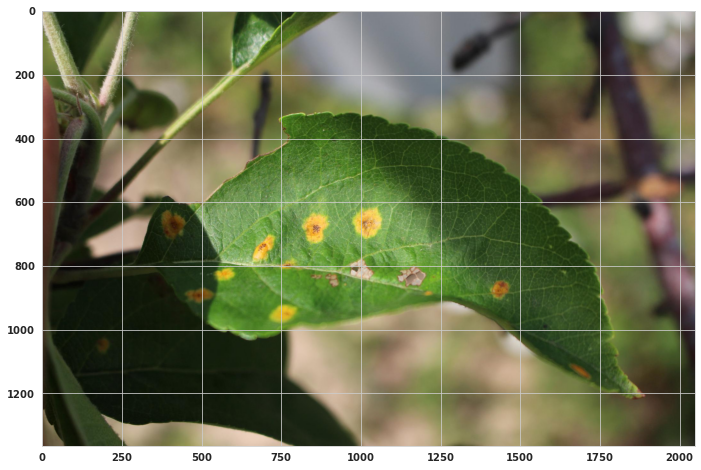

In [18]:
sample_image = rust_image_1
plt.figure(figsize = (12, 8))
plt.imshow(sample_image)

## Image Denoising :

Many image smoothing techniques like Gaussian Blurring, Median Blurring etc were good to some extent in removing small quantities of noise. In those techniques, we took a small neighbourhood around a pixel and performed some operations like gaussian weighted average, median of the values etc to replace the central element. In short, noise removal at a pixel was local to its neighbourhood.

There is a property of noise. Noise is generally considered to be a random variable with zero mean.

Suppose we hold a static camera to a certain location for a couple of seconds. This will give us plenty of frames, or a lot of images of the same scene. Then averaging all the frames, we compare the final result and first frame. Reduction in noise would be easily observed.

So idea is simple, we need a set of similar images to average out the noise. Considering a small window (say 5x5 window) in the image, chance is large that the same patch may be somewhere else in the image. Sometimes in a small neighbourhood around it. Hence, using these similar patches together averaging them can lead to an efficient denoised image.

This method is Non-Local Means Denoising. It takes more time compared to blurring techniques, but the result are very satisfying.

Denoising illustration :

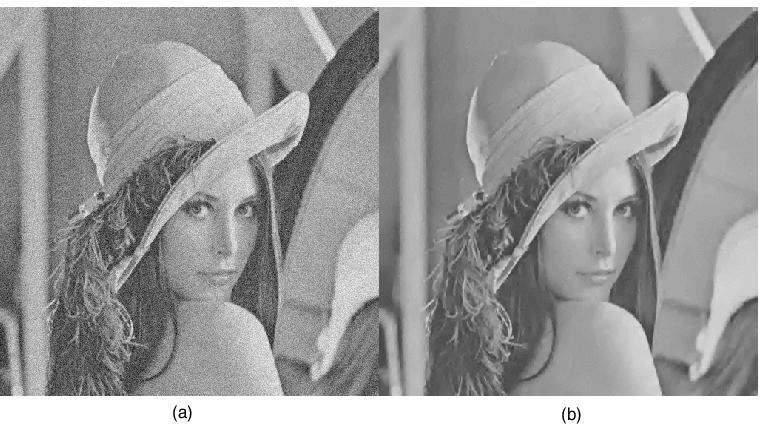

## OpenCV implementation of the aforementioned approach :

cv2.fastNlMeansDenoisingColored() - Works on Colored images cv2.fastNlMeansDenoising() - Works on graysacle images

Common arguments are:

h : parameter deciding filter strength. Higher h value removes noise better, but removes details of image also. (10 is ok)
hForColorComponents : same as h, but for color images only. (normally same as h)
templateWindowSize : should be odd. (recommended 7)
searchWindowSize : should be odd. (recommended 21)

In [19]:
def non_local_means_denoising(image) : 
    denoised_image = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)
    return denoised_image

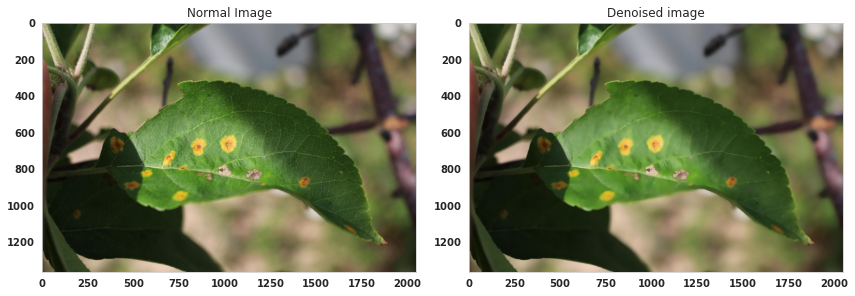

In [20]:
denoised_image = non_local_means_denoising(sample_image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Normal Image")

plt.subplot(1,2,2)  
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised image")    
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

### Edge detection : 
Edge detection is one of the fundamental operation in image processing. Using this, we can reduce the amount of pixels while maintaining the structural aspect of the images. This can be done using :

* First derivative based Sobel filter(for thicker edges)
* Second derivative based Laplacian filter(for finer edges)

Here, we want to consider the area containing only the leaf, while ignoring the background green. Hence, we use Sobel filter to identify the prominent edge of the leaf.

In [21]:
def sobel_edge_detection(image):
  """
  Using Sobel filter

  Sobel filter takes the following arguments : 
  1. Original Image
  2. Depth of the destination image
  3. Order of derivative x
  4. Order of derivative y
  5. Kernel size for convolutions

  f(Image, depth, order_dx, order_dy, kernel_size) 
  """
  sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize = 5)
  sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize = 5)
  return sobel_x, sobel_y

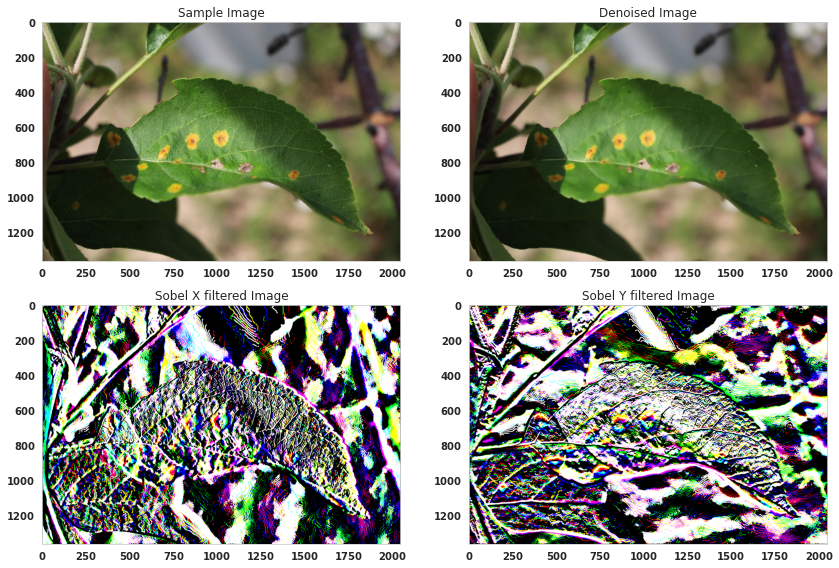

In [22]:
s_img_x, s_img_y = sobel_edge_detection(denoised_image)

plt.figure(figsize = (12, 8))
plt.subplot(2,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Sample Image")

plt.subplot(2,2,2)
plt.imshow(denoised_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised Image")

plt.subplot(2,2,3)
plt.imshow(s_img_x, cmap = "gray")
plt.grid(False)
plt.title("Sobel X filtered Image")

plt.subplot(2,2,4)
plt.imshow(s_img_y, cmap = "gray")
plt.grid(False)
plt.title("Sobel Y filtered Image")

# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

Using sobel filter we found the edges, however for further pre-processing we aim to consider only the area of the leaf, that is the fine textured area we see in the gradient images. For that, we will use a much powerful inbuilt function of open-CV called Canny(). This function will return the edge coordinates.

Entire read is available on the OpenCV webpage :

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_canny/py_canny.html#canny

## Canny Edge Detector : 

The Canny filter is a multi-stage edge detector. It uses a filter based on the derivative of a Gaussian in order to compute the intensity of the gradients.The Gaussian reduces the effect of noise present in the image. Then, potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude. Finally, edge pixels are kept or removed using hysteresis thresholding on the gradient magnitude. 

The Canny has three adjustable parameters: the width of the Gaussian (the noisier the image, the greater the width), and the low and high threshold for the hysteresis thresholding. 

The Canny edge detection algorithm is composed of 5 steps:

* Noise reduction;
* Gradient calculation;
* Non-maximum suppression;
* Double threshold;
* Edge Tracking by Hysteresis.

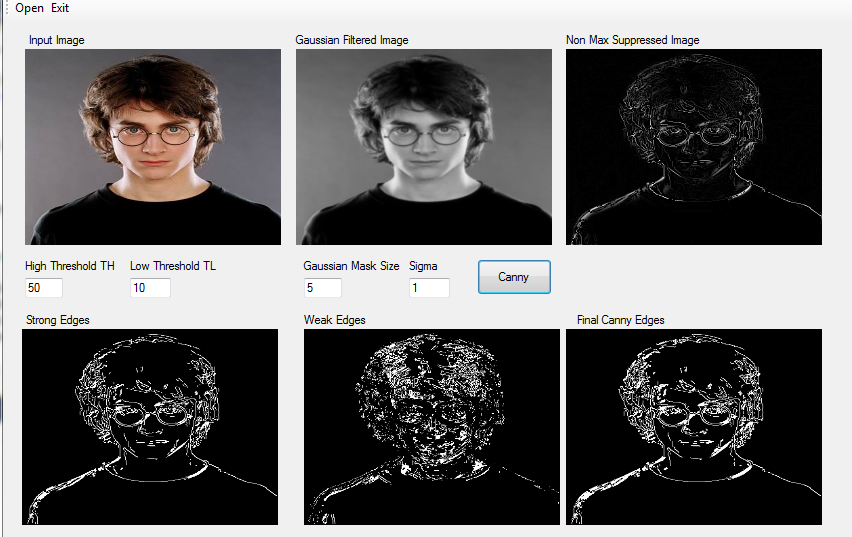   

### Noise Reduction : 

One way to get rid of the noise on the image, is by applying Gaussian blur to smooth it. To do so, image convolution technique is applied with a Gaussian Kernel (3x3, 5x5, 7x7 etc…). The kernel size depends on the expected blurring effect. Basically, the smallest the kernel, the less visible is the blur. 

### Gradient Calculation : 

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators.

The result is almost the expected one, but we can see that some of the edges are thick and others are thin. Non-Max Suppression step will help us mitigate the thick ones.

### Non-Maximum Supression : 

Ideally, the final image should have thin edges. Thus, we must perform non-maximum suppression to thin out the edges.


### Double Threshold : 

The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:

* Strong pixels are pixels that have an intensity so high that we are sure they contribute to the final edge.

* Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.

* Other pixels are considered as non-relevant for the edge.

Therefore, the significance of having two values in double threshold : 

* High threshold is used to identify the strong pixels (intensity higher than the high threshold)

* Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)

* All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.



### Hysteresis : 

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one. 

We will be using OpenCV's implementation of Canny edge detection. This was the theory involved behind the entire process. 

Further information can be found on OpenCV's documentation : https://docs.opencv.org/trunk/da/d22/tutorial_py_canny.html 

In [23]:
from collections import deque
def canny_edge_detection(image):
  edges = cv2.Canny(image, 100, 200) 
  return edges

def primary_roi(original_image, edge_image):
  edge_coordinates = deque()
  for i in tqdm(range(edge_image.shape[0])):
    for j in range(edge_image.shape[1]):
      if edge_image[i][j] != 0 :
        edge_coordinates.append((i, j))
  
  min_row = edge_coordinates[np.argsort([coordinate[0] for coordinate in edge_coordinates])[0]][0]
  max_row = edge_coordinates[np.argsort([coordinate[0] for coordinate in edge_coordinates])[-1]][0]
  min_col = edge_coordinates[np.argsort([coordinate[1] for coordinate in edge_coordinates])[0]][1]
  max_col = edge_coordinates[np.argsort([coordinate[1] for coordinate in edge_coordinates])[-1]][1]
  
  new_image = original_image.copy()
  new_edge_image = edge_image.copy()
  
  new_image[min_row - 10 : min_row + 10, min_col : max_col] = [255, 0, 0]
  new_image[max_row - 10 : max_row + 10, min_col : max_col] = [255, 0, 0]
  new_image[min_row : max_row , min_col - 10 : min_col + 10] = [255, 0, 0]
  new_image[min_row : max_row , max_col - 10 : max_col + 10] = [255, 0, 0]

  new_edge_image[min_row - 10 : min_row + 10, min_col : max_col] = [255]
  new_edge_image[max_row - 10 : max_row + 10, min_col : max_col] = [255]
  new_edge_image[min_row : max_row , min_col - 10 : min_col + 10] = [255]
  new_edge_image[min_row : max_row , max_col - 10 : max_col + 10] = [255]

  roi_image = new_image[min_row : max_row, min_col : max_col]
  edge_roi_image = new_edge_image[min_row : max_row, min_col : max_col]
  
  
  return roi_image, edge_roi_image

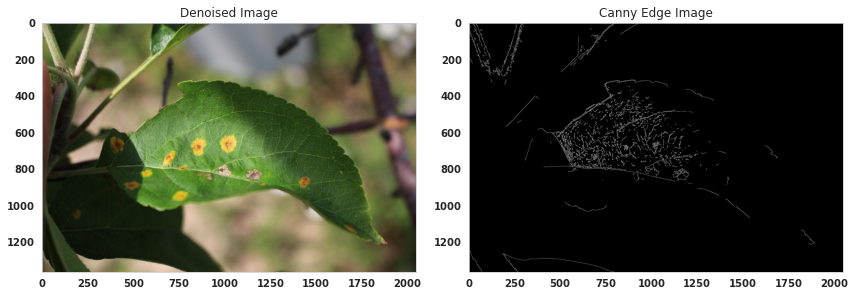

In [24]:
plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(sample_image, cmap = "gray")
plt.grid(False)
plt.title("Denoised Image")

edge_image = canny_edge_detection(sample_image) 

plt.subplot(1,2,2)
plt.imshow(edge_image, cmap = "gray")
plt.grid(False)
plt.title("Canny Edge Image")
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


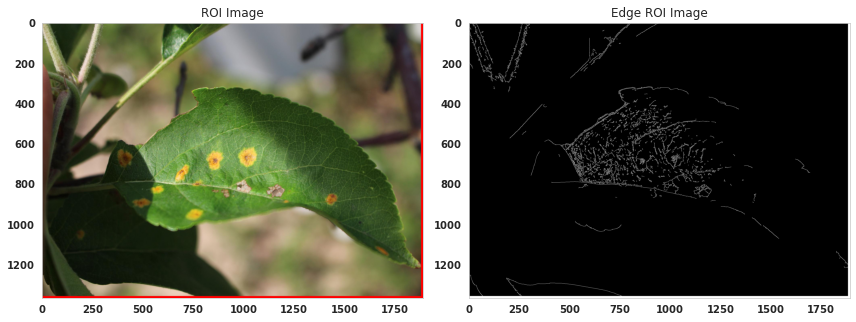

In [25]:
roi_image, edge_roi_image = primary_roi(sample_image, edge_image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(roi_image, cmap = "gray")
plt.grid(False)
plt.title("ROI Image")

plt.subplot(1,2,2)
plt.imshow(edge_roi_image, cmap = "gray")
plt.grid(False)
plt.title("Edge ROI Image")  
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()

## Histogram Equalization in ROI section of the whole image
### First of all, why can we not apply histogram equalization directly to an RGB image?
Histogram equalization is a non-linear process. Channel splitting and equalizing each channel separately is incorrect. Equalization involves intensity values of the image, not the color components. So for a simple RGB color image, histogram equalization cannot be applied directly on the channels. It needs to be applied in such a way that the intensity values are equalized without disturbing the color balance of the image. So, the first step is to convert the color space of the image from RGB into one of the color spaces that separates intensity values from color components. Some of the possible options are HSV/HLS, YUV, YCbCr, etc. YCbCr is preferred as it is designed for digital images. Perform histogram equalization on the intensity plane Y. Now convert the resultant YCbCr image back to RGB.

(Excerpt taken from :

https://prateekvjoshi.com/2013/11/22/histogram-equalization-of-rgb-images/ )

In [26]:
def histogram_equalization(roi_image):
  image_ycrcb = cv2.cvtColor(roi_image, cv2.COLOR_RGB2YCR_CB)
  y_channel = image_ycrcb[:, :, 0] # apply histogram equalization on this channel
  cr_channel = image_ycrcb[:, :, 1]
  cb_channel = image_ycrcb[:, :, 2]
  # local histogram equalization
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  equalized = clahe.apply(y_channel)
  equalized_image = cv2.merge([equalized, cr_channel, cb_channel])
  equalized_image = cv2.cvtColor(equalized_image, cv2.COLOR_YCR_CB2RGB)
  return equalized_image

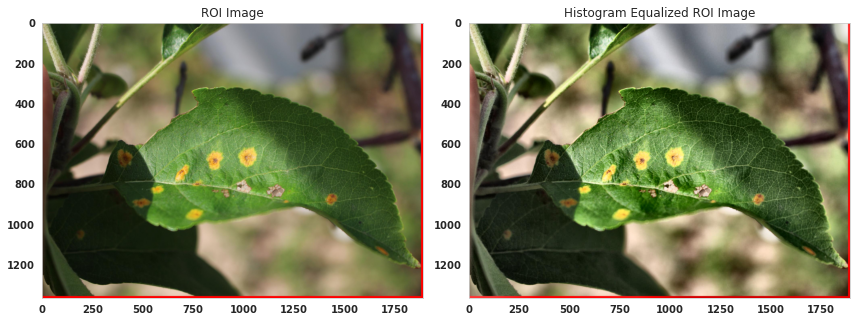

In [27]:
equalized_roi_image = histogram_equalization(roi_image)

plt.figure(figsize = (12, 8))
plt.subplot(1,2,1)
plt.imshow(roi_image, cmap = "gray")
plt.grid(False)
plt.title("ROI Image")

plt.subplot(1,2,2)
plt.imshow(equalized_roi_image, cmap = "gray")
plt.grid(False)
plt.title("Histogram Equalized ROI Image")  
# Automatically adjust subplot parameters to give specified padding.
plt.tight_layout()